# Stock Market Prediction And Forecasting Using Stacked LSTM

## Import necessary libraries

In [1]:
#for reading csv files
import pandas as pd
#for plotting data
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

### Read stock market data available in the same directory and print it

In [2]:
df = pd.read_csv("NSE-TATAGLOBAL.csv")

In [3]:
df

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
...,...,...,...,...,...,...,...,...
2030,2010-07-27,117.60,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.10,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.80,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.30,122.00,120.25,120.75,120.90,293312,355.17


### Converting Date dtype from object to Datetime

In [4]:
df['Date']

0       2018-09-28
1       2018-09-27
2       2018-09-26
3       2018-09-25
4       2018-09-24
           ...    
2030    2010-07-27
2031    2010-07-26
2032    2010-07-23
2033    2010-07-22
2034    2010-07-21
Name: Date, Length: 2035, dtype: object

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date']

0      2018-09-28
1      2018-09-27
2      2018-09-26
3      2018-09-25
4      2018-09-24
          ...    
2030   2010-07-27
2031   2010-07-26
2032   2010-07-23
2033   2010-07-22
2034   2010-07-21
Name: Date, Length: 2035, dtype: datetime64[ns]

### Plotting all the features against the year of Date 

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

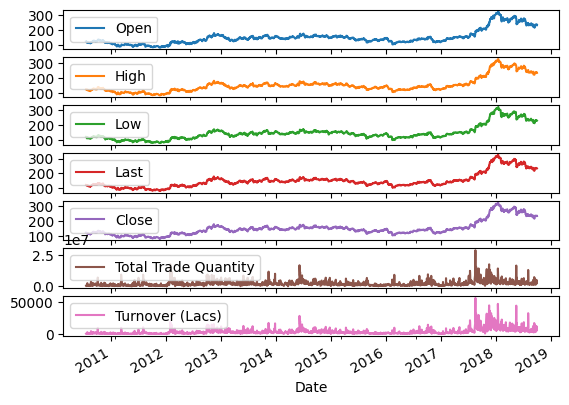

In [6]:
plot_features = df.drop('Date',axis=1)
plot_features.index = df['Date']
plot_features.plot(subplots = True)

In [7]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Date,2035,2014-08-20 14:43:06.339066112,2010-07-21 00:00:00,2012-07-28 12:00:00,2014-08-14 00:00:00,2016-09-10 12:00:00,2018-09-28 00:00:00,NaN
Open,2035.0,149.713735,81.1,120.025,141.5,157.175,327.7,48.664509
High,2035.0,151.992826,82.8,122.1,143.4,159.4,328.75,49.413109
Low,2035.0,147.293931,80.0,118.3,139.6,155.15,321.65,47.931958
Last,2035.0,149.474251,81.0,120.075,141.1,156.925,325.95,48.73257
Close,2035.0,149.45027,80.95,120.05,141.25,156.9,325.75,48.71204
Total Trade Quantity,2035.0,2335681.404423,39610.0,1146444.5,1783456.0,2813594.0,29191015.0,2091778.130824
Turnover (Lacs),2035.0,3899.980565,37.04,1427.46,2512.03,4539.015,55755.08,4570.767877


### Creating a new data frame as data_frame

In [8]:
data_frame = df[['Date','Close']]
data_frame

,Date,Close
0,2018-09-28,233.75
1,2018-09-27,233.25
2,2018-09-26,234.25
3,2018-09-25,236.10
4,2018-09-24,233.30
...,...,...
2030,2010-07-27,118.65
2031,2010-07-26,117.60
2032,2010-07-23,120.65
2033,2010-07-22,120.90


### Plotting Date vs Close

In [9]:
data_frame.index = data_frame.pop('Date')
data_frame

,Close
Date,
2018-09-28,233.75
2018-09-27,233.25
2018-09-26,234.25
2018-09-25,236.10
2018-09-24,233.30
...,...
2010-07-27,118.65
2010-07-26,117.60
2010-07-23,120.65


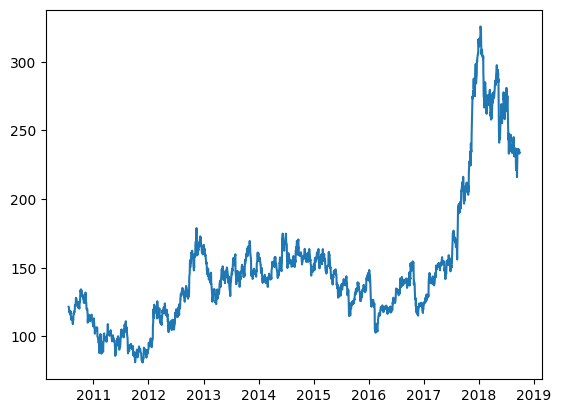

In [10]:
plt.plot(data_frame.index,data_frame['Close'])

### Preparing our data_frame for LSMT

In [11]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(data_frame,steps):
    #deep copy of data_frame to dataframe
    dataframe = dc(data_frame)

    #creates new columns with previous close data
    for i in range(1,steps+1):
        dataframe[f'Close(t-{i})'] = dataframe['Close'].shift(-i)
        
    dataframe.dropna(inplace = True)
    return dataframe
    

In [12]:
lookback = 7
shifted_data_frame = prepare_dataframe_for_lstm(data_frame,lookback)
shifted_data_frame

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2018-09-28,233.75,233.25,234.25,236.10,233.30,234.60,234.90,235.05
2018-09-27,233.25,234.25,236.10,233.30,234.60,234.90,235.05,236.60
2018-09-26,234.25,236.10,233.30,234.60,234.90,235.05,236.60,233.95
2018-09-25,236.10,233.30,234.60,234.90,235.05,236.60,233.95,222.65
2018-09-24,233.30,234.60,234.90,235.05,236.60,233.95,222.65,216.00
...,...,...,...,...,...,...,...,...
2010-08-05,114.05,116.50,118.30,117.30,116.05,116.60,118.25,118.65
2010-08-04,116.50,118.30,117.30,116.05,116.60,118.25,118.65,117.60
2010-08-03,118.30,117.30,116.05,116.60,118.25,118.65,117.60,120.65


### Running scaler on all of our data to range(-1, 1)

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1,1))
shifted_data_frame_as_np = scaler.fit_transform(shifted_data_frame)
shifted_data_frame_as_np

array([[ 0.24836601,  0.24428105,  0.25245098, ...,  0.25531046,
         0.25776144,  0.25898693],
       [ 0.24428105,  0.25245098,  0.26756536, ...,  0.25776144,
         0.25898693,  0.27165033],
       [ 0.25245098,  0.26756536,  0.24468954, ...,  0.25898693,
         0.27165033,  0.25      ],
       ...,
       [-0.69485294, -0.70302288, -0.71323529, ..., -0.69199346,
        -0.7005719 , -0.67565359],
       [-0.70302288, -0.71323529, -0.70874183, ..., -0.7005719 ,
        -0.67565359, -0.67361111],
       [-0.71323529, -0.70874183, -0.69526144, ..., -0.67565359,
        -0.67361111, -0.66830065]])

### Getting our X features and y targets from shifted_data_frame_as_np

In [14]:
X = shifted_data_frame_as_np[:, 1:]
y = shifted_data_frame_as_np[:, 0]
X.shape, y.shape

((2028, 7), (2028,))

In [15]:
X = dc(np.flip(X, axis=1))
X

array([[ 0.25898693,  0.25776144,  0.25531046, ...,  0.26756536,
         0.25245098,  0.24428105],
       [ 0.27165033,  0.25898693,  0.25776144, ...,  0.24468954,
         0.26756536,  0.25245098],
       [ 0.25      ,  0.27165033,  0.25898693, ...,  0.25531046,
         0.24468954,  0.26756536],
       ...,
       [-0.67565359, -0.7005719 , -0.69199346, ..., -0.70874183,
        -0.71323529, -0.70302288],
       [-0.67361111, -0.67565359, -0.7005719 , ..., -0.69526144,
        -0.70874183, -0.71323529],
       [-0.66830065, -0.67361111, -0.67565359, ..., -0.69199346,
        -0.69526144, -0.70874183]])

### Spliting the data into train and test

In [16]:
split_index = int(len(X) * 0.95)
split_index

1926

In [17]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1926, 7), (102, 7), (1926,), (102,))

In [18]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1926, 7, 1), (102, 7, 1), (1926, 1), (102, 1))

In [19]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1926, 7, 1]),
 torch.Size([102, 7, 1]),
 torch.Size([1926, 1]),
 torch.Size([102, 1]))

In [20]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [21]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### LSTM model

In [22]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
# model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [23]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [24]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0], batch[1]
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

### Initializing learning_rate, epochs and optimizer and running epochs to check for loss

In [25]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.194

Val Loss: 0.041
***************************************************

Epoch: 2
Batch 100, Loss: 0.064

Val Loss: 0.002
***************************************************

Epoch: 3
Batch 100, Loss: 0.025

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.013

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.007

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.004

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.003

Val Loss: 0.001
***************************************************

Epoch: 8
Batch 100, Loss: 0.003

Val Loss: 0.001
***************************************************

Epoch: 9
Batch 100, Loss: 0.002

Val Loss: 0.001
***************************************************

Epoch: 10
Batch 100, Loss: 0.002

Val Loss: 0.001
********************************

### Prediction using the model along with the plot

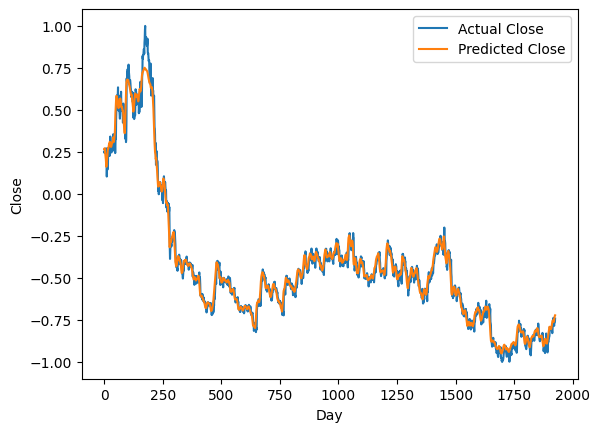

array([[ 0.2667924 ],
       [ 0.27090308],
       [ 0.27173516],
       ...,
       [-0.7319217 ],
       [-0.7249929 ],
       [-0.72237587]], dtype=float32)

In [37]:
with torch.no_grad():
    predicted = model(X_train).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
predicted

### Making Date column the index of df

In [9]:
df.index = df.pop('Date')
df

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
...,...,...,...,...,...,...,...
2010-07-27,117.60,119.50,112.00,118.80,118.65,586100,694.98
2010-07-26,120.10,121.00,117.10,117.10,117.60,658440,780.01
2010-07-23,121.80,121.95,120.25,120.35,120.65,281312,340.31


#### We are only intrested in closing value and date

In [47]:
data = df[df.index,['Close']]
data

InvalidIndexError: (RangeIndex(start=0, stop=2035, step=1), ['Close'])

#### plotting a graph for Date against close column

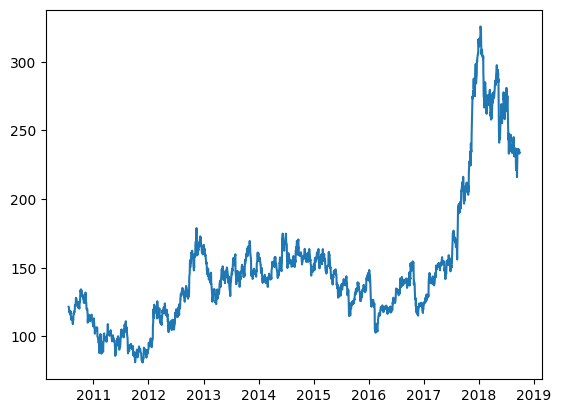

In [15]:
plt.plot(df.index,df['Close'])